# British Airways Customer Review Analysis

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [ ]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [ ]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


### Data Collection via Web Scraping

To simulate real-world data acquisition, we scrape customer review data from the British Airways section of the Skytrax website using the `requests` and `BeautifulSoup` libraries.

The scraper collects reviews from 10 paginated result pages, with 100 reviews per page, resulting in approximately 1,000 text entries. The extracted text is stored in a pandas DataFrame and saved locally as a CSV file for downstream analysis.

This forms the **Extract** phase of our end-to-end ETL pipeline.


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

df = pd.DataFrame()
df["reviews"] = reviews
df.head()

df.to_csv("BA_reviews.csv")


### Predictive Modeling Overview

In this section, we prepare the dataset for predictive modeling by encoding categorical variables and defining the feature matrix `X` and the target variable `y`. We then build a Random Forest classifier using 5-fold cross-validation to evaluate model performance. 

The model evaluation focuses on key metrics including precision, recall, and F1 score, adjusting the decision threshold to 0.3 to better capture the positive class. Feature importances are averaged across folds and visualized to identify the top contributing variables influencing booking completion.

This process simulates a real-world machine learning pipeline, covering data preparation, model training, threshold tuning, evaluation, and interpretation of feature significance.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, classification_report, f1_score, precision_recall_curve
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE

Cross-Validation Accuracy Scores: [0.8553 0.8505 0.8475 0.8506 0.8563]
Mean Accuracy: 0.85204


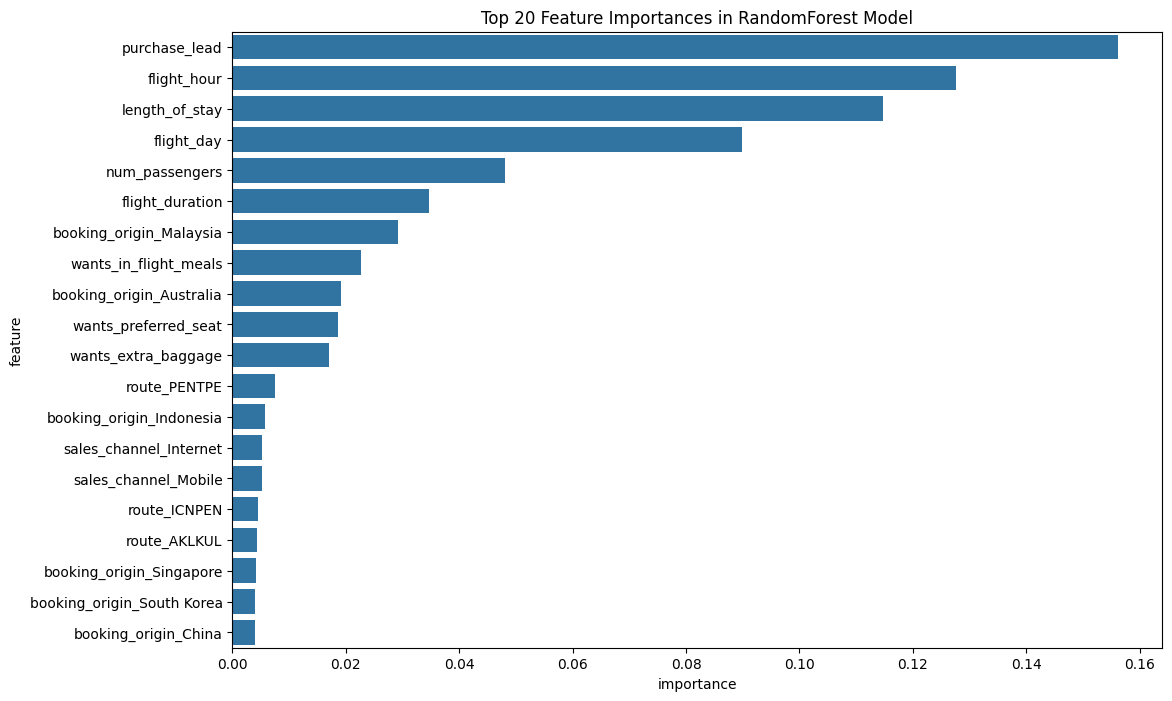

Mean Precision: 0.38709052962890195
Mean Recall: 0.44469064459886154
Mean F1 Score: 0.413821062152655


In [ ]:
# 特征和目标变量
X = df.drop(columns=['booking_complete'])
y = df['booking_complete']

# 将分类变量进行编码（假设所有分类变量都需要编码）
X = pd.get_dummies(X)



# 创建K-fold交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 创建随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 初始化存储精确率和召回率的列表
precision_scores = []
recall_scores = []
f1_scores = []

# 决策阈值
threshold = 0.3

# 初始化存储特征重要性的数组
feature_importances = np.zeros(X.shape[1])

# 进行K-fold交叉验证，并评估模型
accuracy_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {accuracy_scores}")
print(f"Mean Accuracy: {np.mean(accuracy_scores)}")

# 训练模型并计算特征重要性
feature_importances = np.zeros(X.shape[1])
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 使用SMOTE进行过采样
    #smote = SMOTE(random_state=42)
    #X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    #rf_model.fit(X_train_resampled, y_train_resampled)
    rf_model.fit(X_train, y_train)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

    # 调整阈值
    y_pred = (y_pred_proba >= threshold).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # 累加特征重要性
    feature_importances += rf_model.feature_importances_

# 取特征重要性的平均值
feature_importances /= kf.get_n_splits()

# 创建特征重要性数据框
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# 只显示前20个最重要的特征
top_features = feature_importances_df.head(20)

# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Feature Importances in RandomForest Model')
plt.show()

# 计算平均精确率、召回率和F1得分
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1}")

#### Threshold Tuning and Model Evaluation

To further optimize model performance, we plot Precision, Recall, and F1 Score against different decision thresholds based on the model's predicted probabilities. 

This analysis allows us to understand the trade-offs between precision and recall at various thresholds, and helps in selecting an appropriate threshold (e.g., 0.3) that balances both metrics according to business needs. The F1 Score curve provides additional guidance by indicating the point where the balance between precision and recall is maximized.


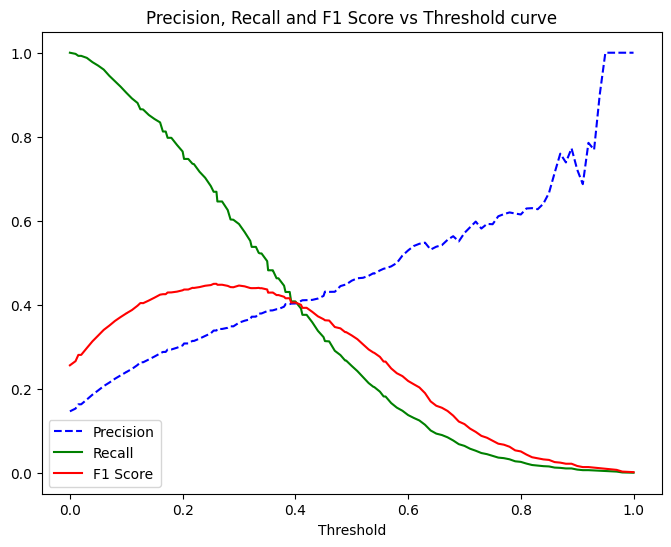

In [ ]:
# 决策阈值调整
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

# 绘制精确率、召回率和F1得分随阈值变化的曲线
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.plot(thresholds, f1_scores[:-1], "r-", label="F1 Score")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision, Recall and F1 Score vs Threshold curve")
plt.show()

In [ ]:
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean f1: {mean_f1}")

Mean Precision: 0.34704707695662274
Mean Recall: 0.5740504466247597
Mean f1: 0.28258114995277234


#### Predictive Modeling with XGBoost

In this section, we build and evaluate a predictive model using the XGBoost classifier, a powerful gradient boosting algorithm commonly used for structured/tabular data. 

We perform 5-fold cross-validation to assess model stability, using precision, recall, and F1 score as the primary evaluation metrics, with a decision threshold set at 0.3 to prioritize recall and balance the positive class detection. SMOTE oversampling is applied during training to mitigate class imbalance, although comparisons without resampling are also considered.

Feature importances are aggregated across folds and visualized to identify the top contributing variables influencing booking completion. This modeling process aims to simulate a real-world machine learning workflow, including data preprocessing, model tuning, performance evaluation, and feature interpretation.


Cross-Validation Accuracy Scores: [0.8553 0.8505 0.8475 0.8506 0.8563]
Mean Accuracy: 0.85204


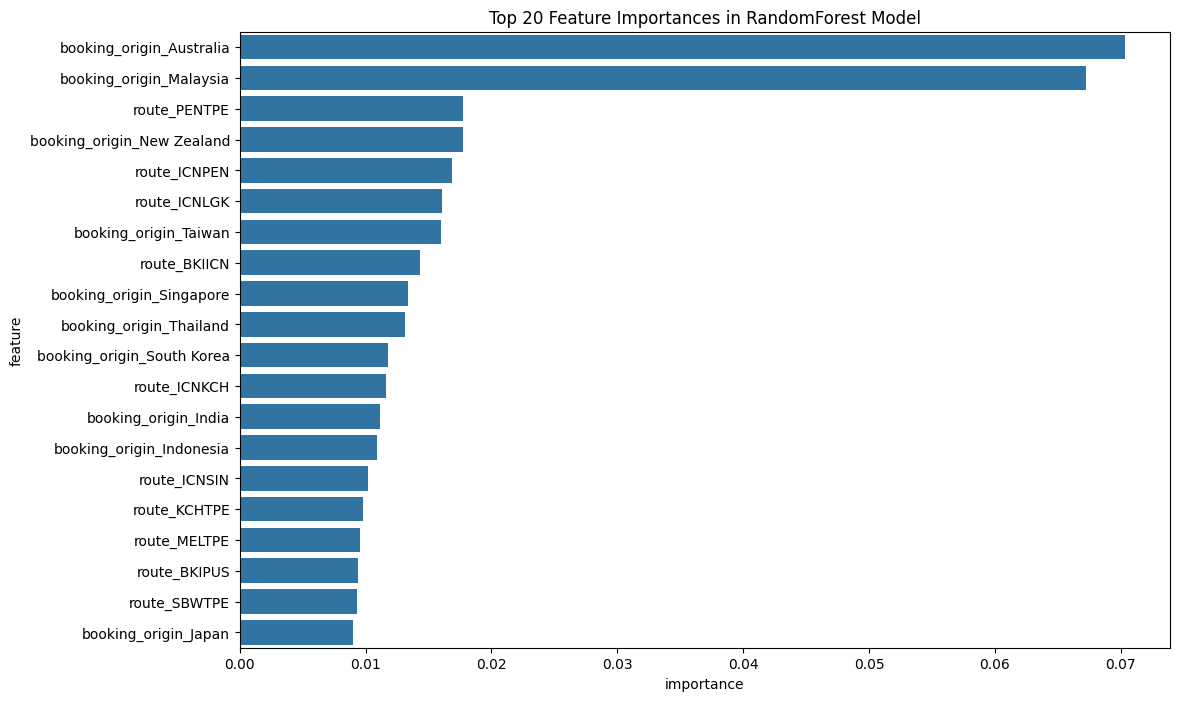

Mean Precision: 0.4012482348140396
Mean Recall: 0.40696994959969607
Mean F1 Score: 0.40387348524187205


In [ ]:
from xgboost import XGBClassifier

# 创建XGBoost模型
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

precision_scores = []
recall_scores = []
f1_scores = []

feature_importances = np.zeros(X.shape[1])

accuracy_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {accuracy_scores}")
print(f"Mean Accuracy: {np.mean(accuracy_scores)}")


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 过采样处理
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    #xgb_model.fit(X_train_resampled, y_train_resampled)
    xgb_model.fit(X_train, y_train)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # 使用最佳阈值
    y_pred = (y_pred_proba >= 0.3).astype(int)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # 累加特征重要性
    feature_importances += xgb_model.feature_importances_

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # 可选：打印每一折的分类报告
    #print(classification_report(y_test, y_pred))

# 取特征重要性的平均值
feature_importances /= kf.get_n_splits()

# 创建特征重要性数据框
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)

# 只显示前20个最重要的特征
top_features = feature_importances_df.head(20)

# 可视化特征重要性
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Feature Importances in RandomForest Model')
plt.show()

# 计算平均精确率、召回率和F1得分
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1}")

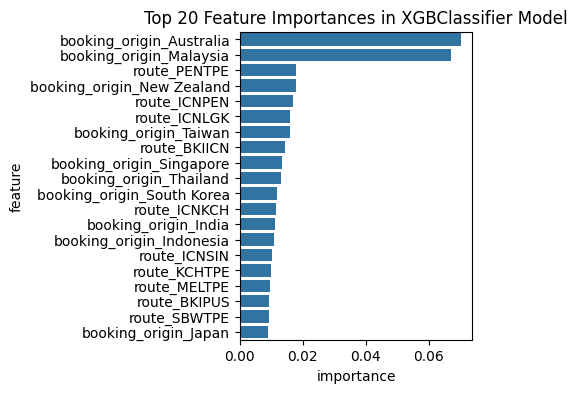

In [ ]:
# 可视化特征重要性
plt.figure(figsize=(3, 4))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Feature Importances in XGBClassifier Model')
plt.show()

#### Model Interpretability with SHAP

To enhance model interpretability, we use SHAP (SHapley Additive exPlanations) to explain the impact of individual features on the XGBoost model’s predictions. 

SHAP values provide a unified measure of feature contribution for each prediction, allowing for a detailed understanding of how each feature affects the model output. We generate a summary plot to visualize the distribution and magnitude of SHAP values across all features, and a bar plot to rank features by their average absolute contribution.

This interpretability step supports transparent model decision-making and identifies the most influential factors driving booking completion predictions.


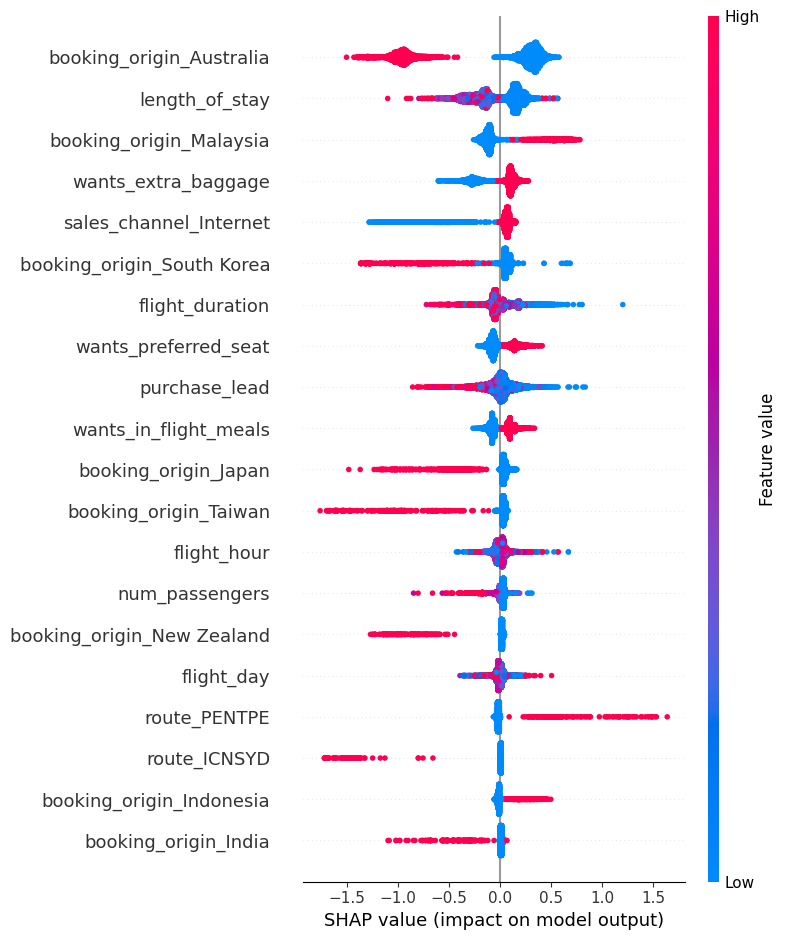

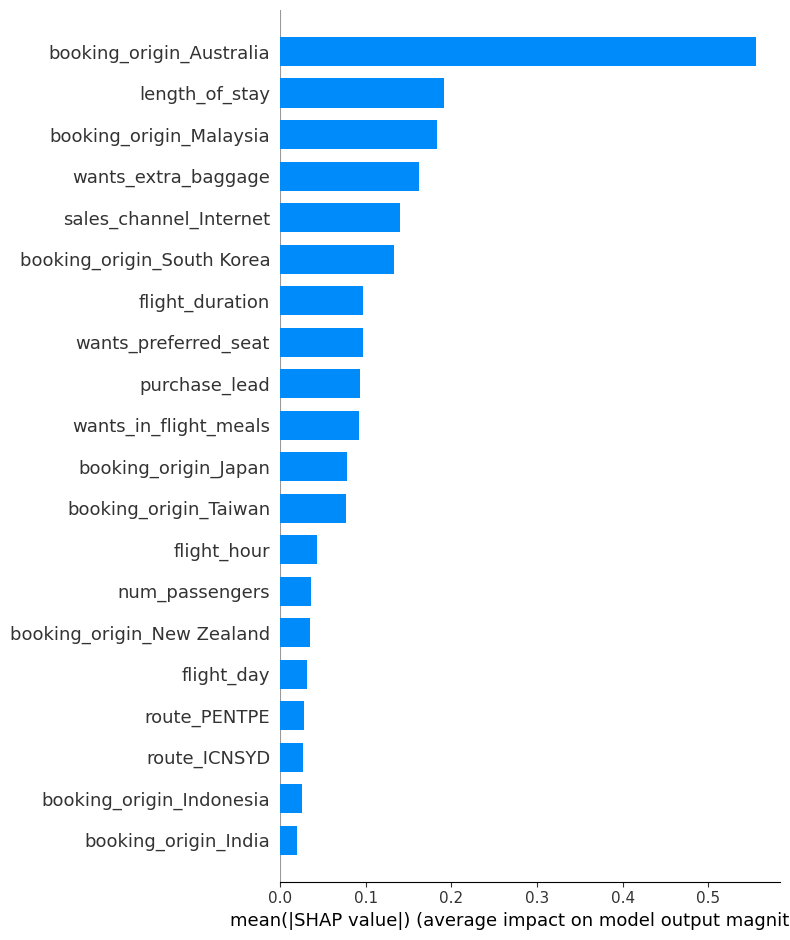

In [ ]:

import shap
# 使用SHAP解释模型
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# 可视化SHAP值 - 汇总图
plt.figure(figsize=(3, 4))
shap.summary_plot(shap_values, X_test)
plt.show()
# 可视化SHAP值 - 柱状图
plt.figure(figsize=(3, 4))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()